In [75]:
import sys
print(sys.version)

3.8.5 (v3.8.5:580fbb018f, Jul 20 2020, 12:11:27) 
[Clang 6.0 (clang-600.0.57)]


In [51]:
#!pip3 install rasterio
#!pip3 install matplotlib
#!pip3 install pyproj
!pip3 install fiona

You should consider upgrading via the '/Users/poojasingh/Documents/hack-a-mae/venv/bin/python -m pip install --upgrade pip' command.


In [105]:
import fiona
import rasterio
import pandas as pd
import numpy as np
import pyproj
from shapely.geometry import box
from shapely.geometry import Point
import geopandas as gpd
from rasterio.mask import mask

from shapely.geometry import Polygon
import matplotlib.pyplot as plt 

array shape: (31327, 48357)
[-3.4e+38 -3.4e+38 -3.4e+38 -3.4e+38 -3.4e+38 -3.4e+38 -3.4e+38 -3.4e+38
 -3.4e+38]
Raster shape: (31327, 48357)
Raster data type: float32
Raster GeoTransform: | 100.00, 0.00,-2493045.00|
| 0.00,-100.00, 3310005.00|
| 0.00, 0.00, 1.00|
Raster CRS: EPSG:5070
27861510
36387786


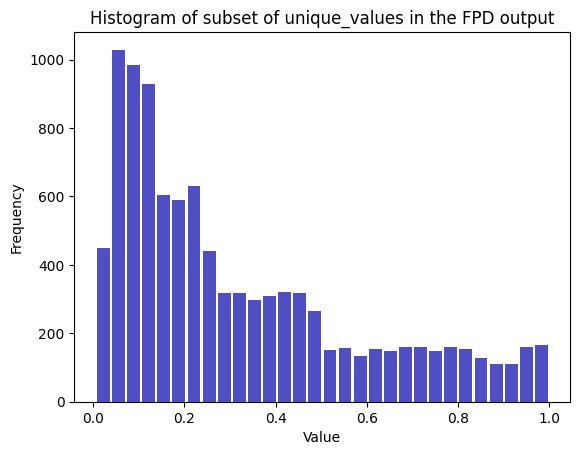

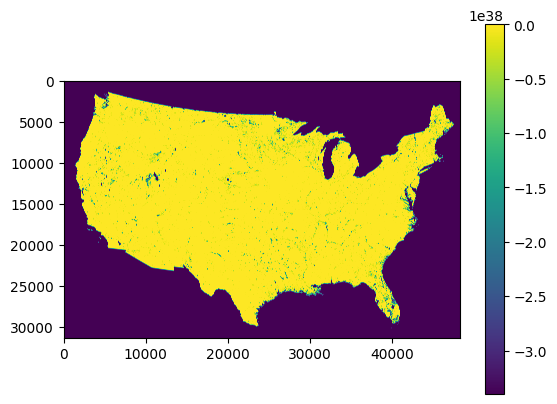

In [96]:
#Step1: Read FPD output tif raster dataset

#Download Flood Data Probability Map (FDP) dataset from here
#https://iopscience.iop.org/article/10.1088/1748-9326/ac4f0f
#https://www.sciencebase.gov/catalog/item/6170694ed34ea36449a67ef7

# Open the raster dataset
with rasterio.open('/Users/poojasingh/Downloads/Output_CONUS_FDP_100m/CONUS_FDP_100m.tif') as dataset:
    
    # Read the dataset's valid data mask as a ndarray.
    #mask = dataset.dataset_mask()
    
    # Read the raster values
    array = dataset.read(1)  # Read the first band. Change 1 to other numbers for different bands
    
    shp = array.shape
    print(f"array shape: {shp}" )
    
    #print first 10 values
    print(array[0, 0:9])
    
    # Print basic info
    print(f"Raster shape: {array.shape}")
    print(f"Raster data type: {array.dtype}")
    print(f"Raster GeoTransform: {dataset.transform}")
    print(f"Raster CRS: {dataset.crs}")
    
    # Get indices where value is equal to 1
    indices = np.where(array == 1)
    
    print(len(indices[0]))
          
    unique_values = np.unique(array)
    print(len(unique_values))   
    
    # Plot histogram of the values
    subset = np.random.choice(unique_values, size=10000)
    plt.hist(subset, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of subset of unique_values in the FPD output')
    plt.show()
    
    # Display raster data using pcolormesh
    # visualize the raster data 
    plt.imshow(array) #optimized
    plt.colorbar()
    plt.show()

In [58]:
#Step2 Download Baltimore County Shape File and clip the FPD raster data for BMC shape

#Download BMC Shapefile
#https://opendata.baltimorecountymd.gov/datasets/BC-GIS::special-flood-hazard-area/explore

#boundary_path = '/Users/poojasingh/Downloads/Special_Flood_Hazard_Area/Special_Flood_Hazard_Area.shp'
boundary_path = '/Users/poojasingh/Downloads/bmc_zoning/Zoning.shp'
raster_path = '/Users/poojasingh/Downloads/Output_CONUS_binary_pres_abs_100m/CONUS_binary_pres_abs_100m.tif'
output_file = '/Users/poojasingh/Downloads/clipped_raster.tif'

#Open BMC Shape file
with fiona.open(boundary_path, 'r') as shapefile:
    shapes = [feature['geometry'] for feature in shapefile]

# open rasterfile
with rasterio.open(raster_path, 'r') as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True) # setting all pixels outside of the feature zone to zero
    out_meta = src.meta

    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    with rasterio.open(output_file, "w", **out_meta) as dest:
        dest.write(out_image)



Raster shape: (1915, 1632)
Raster data type: float32
Raster GeoTransform: | 100.00, 0.00, 1341255.00|
| 0.00,-100.00, 748605.00|
| 0.00, 0.00, 1.00|
Raster CRS: EPSG:5070
Raster shape: (1915, 1632)
Raster data type: float32
Raster GeoTransform: | 100.00, 0.00, 1341255.00|
| 0.00,-100.00, 748605.00|
| 0.00, 0.00, 1.00|
Raster CRS: EPSG:5070


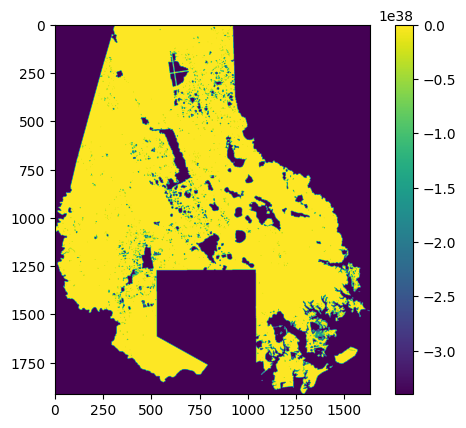

In [60]:
#Step3 Plot clipped raster FPD output

with rasterio.open(output_file) as dataset:
    array = dataset.read(1)  # Read the first band. Change 1 to other numbers for different bands
    
    # Print basic info
    print(f"Raster shape: {array.shape}")
    print(f"Raster data type: {array.dtype}")
    print(f"Raster GeoTransform: {dataset.transform}")
    print(f"Raster CRS: {dataset.crs}")
    
    # Print basic info
    print(f"Raster shape: {array.shape}")
    print(f"Raster data type: {array.dtype}")
    print(f"Raster GeoTransform: {dataset.transform}")
    print(f"Raster CRS: {dataset.crs}")
    
    # Display raster data using pcolormesh
    # visualize the raster data 
    plt.imshow(array) #optimized
    plt.colorbar()
    plt.show()

In [109]:
#Step4: Transform Baltimore county property lat/long data to raster EPSG:5070"  CONUS Albers 

bmc_df = pd.read_csv("/Users/poojasingh/Downloads/BMC_filtered_df.csv");
print(bmc_df.shape)
"""
*** relevant filtered_df  columns
    'Land_Use_Code'
    'Current_Total_Assessment'
    'Current_Date_Assessed'
    'Latitude'
    'Longitude'
"""


def transform_coordinates(df, lat_col='Latitude', lon_col='Longitude', source_crs='EPSG:4326', target_crs='EPSG:5070'):
    """
    Transform a dataframe's latitude and longitude from one CRS to another.

    Parameters:
    - df: DataFrame containing the latitude and longitude columns.
    - lat_col: Name of the latitude column in the dataframe (default is 'latitude').
    - lon_col: Name of the longitude column in the dataframe (default is 'longitude').
    - source_crs: Initial coordinate reference system (default is 'EPSG:4326').
    - target_crs: Target coordinate reference system (default is 'EPSG:5070').

    Returns:
    - DataFrame with transformed latitude and longitude.
    """
    # Convert the dataframe to a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[lon_col], df[lat_col]), crs=source_crs)

    # Transform the coordinates
    gdf = gdf.to_crs(target_crs)

    # Extract the transformed x and y back into the dataframe
    df["Long_5070"] = gdf.geometry.x
    df["Lat_5070"] = gdf.geometry.y
    df["Transform_geometery"] = gdf.geometry

    return df



transformed_df = transform_coordinates(bmc_df)
print(transformed_df.shape)


(2236, 221)
(2236, 224)


In [107]:
#Step5: Create a geodataframe from clipped raster file
with rasterio.open(output_file) as src:
    # Read the first band 
    array = src.read(1)
    
    print(f"clipped FPD data: {array.shape}")
    print(array[0,1631])
    print(array[1914,1631])
    
    # Transform raster coordinates to geographical coordinates
    # This gives a generator of (x, y) tuples
    transformed = (src.xy(row, col) for row, col in np.ndindex(array.shape))
    
    # Create a list of Point geometries with associated values
    data = {'geometry': [], 'value': []}
    for (x, y), value in zip(transformed, array.ravel()):
        data['geometry'].append(Point(x, y))
        data['value'].append(value)

    # Create a GeoDataFrame
    gdf_raster = gpd.GeoDataFrame(data, crs=src.crs)

print(gdf_raster.head())

clipped FPD data: (1915, 1632)
-3.4e+38
-3.4e+38
                         geometry         value
0  POINT (1341305.000 748555.000) -3.400000e+38
1  POINT (1341405.000 748555.000) -3.400000e+38
2  POINT (1341505.000 748555.000) -3.400000e+38
3  POINT (1341605.000 748555.000) -3.400000e+38
4  POINT (1341705.000 748555.000) -3.400000e+38


In [110]:
#Step6: Find the neared FPD geometry from the clipped_raster for BMC transformed coordinates 

print(f"transformed_df.shape: {transformed_df.shape}")

def find_nearest(row):
    # Compute distances between the row's geometry and all geometries in gdf_raster
    distances = gdf_raster.distance(row['Transform_geometery'])
    
    # Find the index of the minimum distance
    nearest_index = distances.idxmin()
    
    nearest_geom = gdf_raster.loc[nearest_index, 'geometry']
    nearest_value = gdf_raster.loc[nearest_index, 'value']
    return pd.Series([nearest_geom, nearest_value], index=['nearest_geometry', 'nearest_value'])

# Applying the function and appending values
transformed_df[['nearest_geometry', 'nearest_value']] = transformed_df.apply(find_nearest, axis=1)

print(f"transformed_df.shape2: {transformed_df.shape}")
print(transformed_df.head())

transformed_df.shape: (2236, 224)
transformed_df.shape: (2236, 226)
   Unnamed: 0 Jurisdiction Code (MDP Field: JURSCODE)  \
0      212995                                    BACO   
1      212999                                    BACO   
2      213001                                    BACO   
3      213029                                    BACO   
4      213037                                    BACO   

  County Name (MDP Field: CNTYNAME)  Account ID (MDP Field: ACCTID)  \
0                  Baltimore County                   4031800012859   
1                  Baltimore County                   4031800012860   
2                  Baltimore County                   4031800012862   
3                  Baltimore County                   4031800012863   
4                  Baltimore County                   4031800012864   

                           Real Property Search Link  \
0  https://sdat.dat.maryland.gov/RealProperty/Pag...   
1  https://sdat.dat.maryland.gov/RealProperty/Pag.

In [114]:
transformed_df.loc[1:10,"nearest_value"]


1    -3.400000e+38
2    -3.400000e+38
3    -3.400000e+38
4    -3.400000e+38
5    -3.400000e+38
6    -3.400000e+38
7    -3.400000e+38
8    -3.400000e+38
9    -3.400000e+38
10   -3.400000e+38
Name: nearest_value, dtype: float32

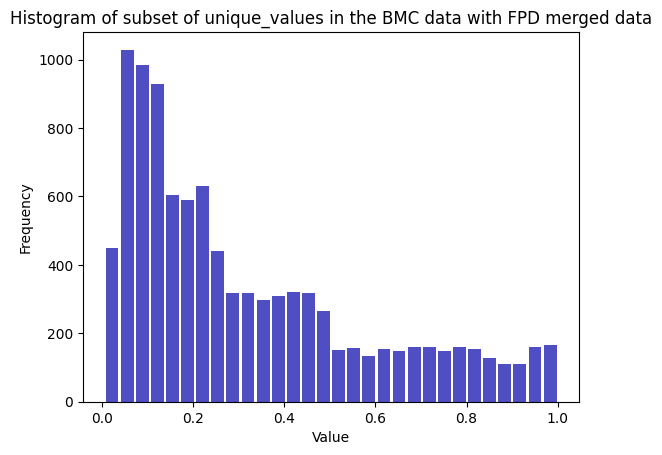

In [115]:
#Step7 Write BMC data with FPD values combined
# Plot histogram of the values
unique_values2 = np.unique(transformed_df.loc[:,"nearest_value"])
subset2 = np.random.choice(unique_values2, size=10000)
plt.hist(subset, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of subset of unique_values in the BMC data with FPD merged data')
plt.show()

transformed_df.to_csv("/Users/poojasingh/Downloads/BMC_merged_with_fpd.csv");